# Add Titles and introductory info here

## Collect Data:

In [1]:
# Import dependencies:

import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from config import api_key
import time   #used for time.sleep

In [2]:
# Generate a random list of 500 unique cities with a reasonably even distribution across the globe

# Set a range for lat and lng that includes the whole Earth
# latitude range is -90 to 90, longitude range is -180 to 180
lats = []
longs = []

lats = np.random.uniform(-90, 90, 25)
longs = np.random.uniform(-180, 180, 25)

#print(lats)
#print(longs)

In [3]:
# zip lists together to form coordinates
lat_long = zip(lats, longs)

In [4]:
# Use citipy to find cities near coordinates

#Import citipy
from citipy import citipy

cities = []
countries = []

for lat_long in lat_long:
    city = citipy.nearest_city(lat_long[0], lat_long[1]).city_name
    country = citipy.nearest_city(lat_long[0], lat_long[1]).country_code
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Print the city count to confirm sufficient count
print(len(cities))
print(len(countries))

24
24


In [5]:
# Format data for improved legibility
cities = [city.title() for city in cities]
countries = [country.upper() for country in countries]

In [6]:
# Build dataframe to hold data
weather_df = pd.DataFrame({"Cities" : cities, "Countries" : countries})
weather_df.head()

,Cities,Countries
0,Bakel,SN
1,Taolanaro,MG
2,Jamestown,SH
3,Nikolskoye,RU
4,Arraial Do Cabo,BR


In [7]:
# Check for NaNs
weather_df.isnull().sum()

Cities       0
Countries    0
dtype: int64

In [8]:
# Add places to hold data for each city

weather_df["Latitude"] = ""
weather_df["Longitude"] = ""
weather_df["Max Temperature (F)"] = ""
weather_df["Humidity (%)"] = ""
weather_df["Cloudiness"] = ""
weather_df["Wind Speed (mph)"] = ""
weather_df["Date"] = ""
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Bakel,SN,,,,,,,
1,Taolanaro,MG,,,,,,,
2,Jamestown,SH,,,,,,,
3,Nikolskoye,RU,,,,,,,
4,Arraial Do Cabo,BR,,,,,,,


In [9]:
# Use OpenWeather to get weather data for generated list of cities, test on one city

base_url = "http://api.openweathermap.org/data/2.5/weather?"
city_name = "Minneapolis"
country_code = "US"
query_url = f"{base_url}q={city_name},{country_code}&appid={api_key}&units=imperial"
#print(query_url) - test url worked
#minneapolis_weather = requests.get(query_url).json()
#minneapolis_weather

In [10]:
# Build a for loop to use the city names to call the OpenWeather API
# Test to ensure that the city has data, otherwise skip
# Generate a print log for each city as it is being processed

my_params = {"appid" : api_key, "units" : "imperial"}

for index, row in weather_df.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    city = row["Cities"]
    country = row["Countries"]
    
    my_params['q'] = f'{city},{country}'
    
    #make request
    cities_weather = requests.get(base_url, params=my_params).json()
    print(index, city)
    try:
        weather_df.loc[index, "Latitude"] = cities_weather["coord"]["lat"]
    except KeyError:
        weather_df.loc[index, "Latitude"] = np.nan
        print("skip")
        continue
       
    weather_df.loc[index, "Longitude"] = cities_weather["coord"]["lon"]
    weather_df.loc[index, "Max Temperature (F)"] = cities_weather["main"]["temp_max"]
    weather_df.loc[index, "Humidity (%)"] = cities_weather["main"]["humidity"]
    weather_df.loc[index, "Cloudiness"] = cities_weather["clouds"]["all"]
    weather_df.loc[index, "Wind Speed (mph)"] = cities_weather["wind"]["speed"]
    weather_df.loc[index, "Date"] = cities_weather["dt"]
    
    time.sleep(1)
        

0 Bakel
1 Taolanaro
skip
2 Jamestown
3 Nikolskoye
4 Arraial Do Cabo
5 Port Hardy
6 Atuona
7 Albany
8 The Valley
9 Alotau
skip
10 Ushuaia
11 Batemans Bay
12 Marquard
13 Wenling
14 Olinda
15 Ndiekro
skip
16 Moree
17 Busselton
18 Flin Flon
19 Hobart
20 Kusye-Aleksandrovskiy
skip
21 Pascagoula
22 Punta Arenas
23 Pevek


In [11]:
#Drop rows with missing values
weather_df.dropna(inplace=True)
weather_df.reset_index(drop=True, inplace=True)
len(weather_df)

20

In [12]:
# Check for humidity outliers
weather_df["Humidity (%)"].max()

88

In [13]:
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Bakel,SN,14.905,-12.4568,72.54,20,80,10.49,1612840358
1,Jamestown,SH,-15.9387,-5.7168,68.45,88,54,14.97,1612840360
2,Nikolskoye,RU,59.7035,30.7861,5,85,90,2.24,1612840102
3,Arraial Do Cabo,BR,-22.9661,-42.0278,72.36,73,100,2.06,1612840075
4,Port Hardy,CA,50.6996,-127.42,37.4,74,1,8.05,1612840363


In [14]:
#Clean up formatting
weather_df = weather_df.convert_dtypes()
weather_df = weather_df.round({"Latitude": 2,"Longitude": 2, "Max Temperature (F)": 1, "Wind Speed (mph)": 1})
weather_df["Date"]=pd.to_datetime(weather_df["Date"],unit='s').dt.strftime('%m-%d-%Y')
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Bakel,SN,14.90,-12.46,72.5,20,80,10.5,02-09-2021
1,Jamestown,SH,-15.94,-5.72,68.4,88,54,15.0,02-09-2021
2,Nikolskoye,RU,59.70,30.79,5.0,85,90,2.2,02-09-2021
3,Arraial Do Cabo,BR,-22.97,-42.03,72.4,73,100,2.1,02-09-2021
4,Port Hardy,CA,50.70,-127.42,37.4,74,1,8.0,02-09-2021


In [15]:
# Save a CSV file containing all weather data

weather_df.to_csv("cities_weather.csv", encoding='utf-8', index=False)

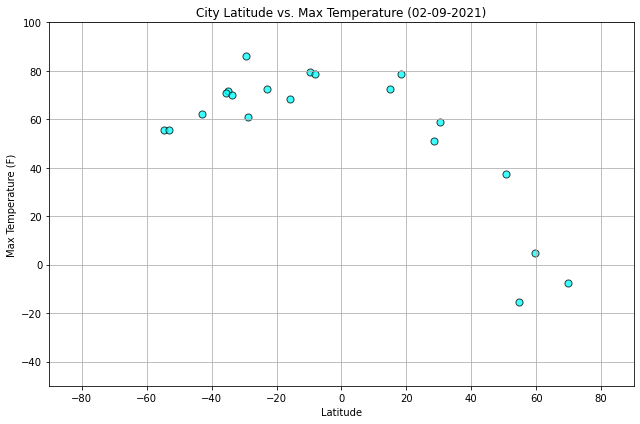

<Figure size 432x288 with 0 Axes>

In [16]:
# Make a scatter plot to show relationship of temperature v latitude

x = weather_df["Latitude"]
y = weather_df["Max Temperature (F)"]
date = weather_df["Date"][0]

plt.figure(figsize=(9,6))
plt.scatter(x, y, marker="o", s=50, facecolor="cyan", edgecolors="black", alpha=0.75, linewidths=1)
plt.xlim(-90,90)
plt.ylim(-50, 100)
plt.title(f"City Latitude vs. Max Temperature ({date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid()
plt.tight_layout()
plt.show()

# Save plot as a PNG file
plt.savefig("temp_plot.png")

## After each plot, add a sentence or two explaining what the code is analyzing.

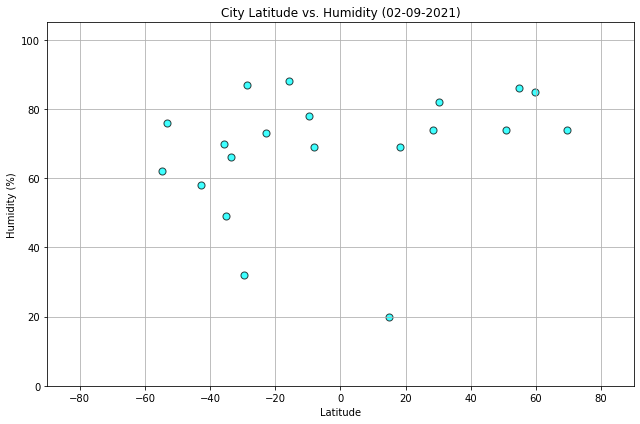

<Figure size 432x288 with 0 Axes>

In [17]:
# Make a scatter plot to show the relationship of humidity v latitude

x = weather_df["Latitude"]
y = weather_df["Humidity (%)"]
date = weather_df["Date"][0]

plt.figure(figsize=(9,6))
plt.scatter(x, y, marker="o", s=50, facecolor="cyan", edgecolors="black", alpha=0.75, linewidths=1)
plt.xlim(-90,90)
plt.ylim(0, 105)
plt.title(f"City Latitude vs. Humidity ({date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()
plt.tight_layout()
plt.show()

# Save plot as a PNG file
plt.savefig("humid_plot.png")

## After each plot, add a sentence or two explaining what the code is analyzing.

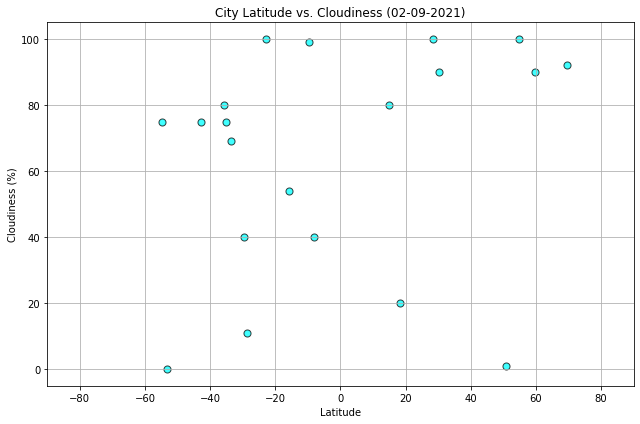

<Figure size 432x288 with 0 Axes>

In [18]:
# Make a scatter plot to show the relationship of cloudiness v latitude

x = weather_df["Latitude"]
y = weather_df["Cloudiness"]
date = weather_df["Date"][0]

plt.figure(figsize=(9,6))
plt.scatter(x, y, marker="o", s=50, facecolor="cyan", edgecolors="black", alpha=0.75, linewidths=1)
plt.xlim(-90,90)
plt.ylim(-5, 105)
plt.title(f"City Latitude vs. Cloudiness ({date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid()
plt.tight_layout()
plt.show()

# Save plot as a PNG file
plt.savefig("cloud_plot.png")

## After each plot, add a sentence or two explaining what the code is analyzing.

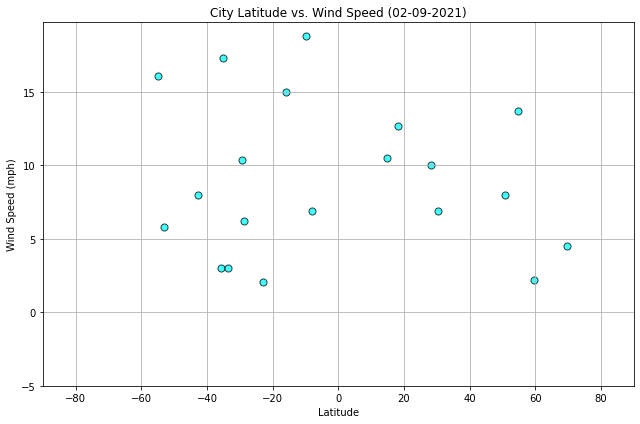

<Figure size 432x288 with 0 Axes>

In [19]:
# Make a scatter plot to show the relationship of wind speed v latitude

x = weather_df["Latitude"]
y = weather_df["Wind Speed (mph)"]
ymax = max(y)
date = weather_df["Date"][0]

plt.figure(figsize=(9,6))
plt.scatter(x, y, marker="o", s=50, facecolor="cyan", edgecolors="black", alpha=0.75, linewidths=1)
plt.xlim(-90,90)
plt.ylim(-5, 1.05*ymax)
plt.title(f"City Latitude vs. Wind Speed ({date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid()
plt.tight_layout()
plt.show()

# Save plot as a PNG file
plt.savefig("wind_plot.png")

## After each plot, add a sentence or two explaining what the code is analyzing.

In [20]:
# The second requirement is to run linear regression on each relationship. This time, separate the plots 
# into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 
# degrees latitude):

In [21]:
# Study data files


In [23]:
# Create bins and bin data

bins = [-90, 0, 90]
labels = ["south", "north"]
weather_df["Hemisphere"] = pd.cut(weather_df["Latitude"], bins=bins, labels=labels)
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Bakel,SN,14.90,-12.46,72.5,20,80,10.5,02-09-2021,north
1,Jamestown,SH,-15.94,-5.72,68.4,88,54,15.0,02-09-2021,south
2,Nikolskoye,RU,59.70,30.79,5.0,85,90,2.2,02-09-2021,north
3,Arraial Do Cabo,BR,-22.97,-42.03,72.4,73,100,2.1,02-09-2021,south
4,Port Hardy,CA,50.70,-127.42,37.4,74,1,8.0,02-09-2021,north


In [24]:
# Split data into two frames, one for each hemisphere

weather_north_df = weather_df.loc[weather_df["Latitude"] > 0]
weather_north_df.reset_index(inplace=True, drop=True)
weather_north_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Bakel,SN,14.90,-12.46,72.5,20,80,10.5,02-09-2021,north
1,Nikolskoye,RU,59.70,30.79,5.0,85,90,2.2,02-09-2021,north
2,Port Hardy,CA,50.70,-127.42,37.4,74,1,8.0,02-09-2021,north
3,The Valley,AI,18.22,-63.06,78.8,69,20,12.7,02-09-2021,north
4,Wenling,CN,28.37,121.36,51.0,74,100,10.0,02-09-2021,north


In [25]:
# Same for southern hemisphere

weather_south_df = weather_df.loc[weather_df["Hemisphere"] == "south"]
weather_south_df.reset_index(inplace=True, drop=True)
weather_south_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Jamestown,SH,-15.94,-5.72,68.4,88,54,15.0,02-09-2021,south
1,Arraial Do Cabo,BR,-22.97,-42.03,72.4,73,100,2.1,02-09-2021,south
2,Atuona,PF,-9.80,-139.03,79.6,78,99,18.8,02-09-2021,south
3,Albany,AU,-35.02,117.89,71.6,49,75,17.3,02-09-2021,south
4,Ushuaia,AR,-54.80,-68.30,55.4,62,75,16.1,02-09-2021,south


In [26]:
# Northern Hemisphere - Temperature (F) vs. Latitude
# Southern Hemisphere - Temperature (F) vs. Latitude

# define values for northern hemisphere
xn = weather_north_df["Latitude"]
yn = weather_north_df["Max Temperature (F)"]

#calculate regression
(slope_n, intercept_n, rvalue_n, pvalue_n, stderr_n) = linregress(xn, yn)
regress_n = xn * slope_n + intercept_n
line_eq_n = "y=" + str(round(slope_n,2)) + "x + " + str(round(intercept_n,2))
print(line_eq_n)

y=-1.67x + 103.19


In [27]:
#define values for southern hemisphere
xs = weather_south_df["Latitude"]
ys = weather_south_df["Max Temperature (F)"]

#calculate regression
(slope_s, intercept_s, rvalue_s, pvalue_s, stderr_s) = linregress(xs, ys)
regress_s = xs * slope_s + intercept_s
line_eq_s = "y=" + str(round(slope_s,2)) + "x + " + str(round(intercept_s,2))
print(line_eq_s)

y=0.46x + 83.51


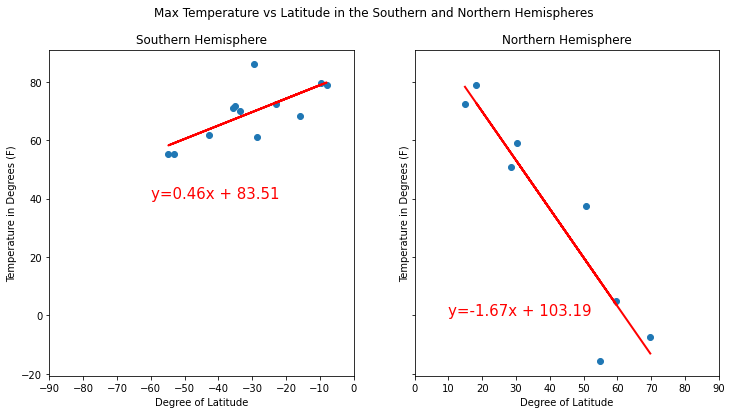

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Max Temperature vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs, ys)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Temperature in Degrees (F)")
ax1.plot(xs, regress_s, color='red', linewidth=2)
ax1.annotate(line_eq_s, (-60,40), fontsize=15, color="red")
ax2.scatter(xn, yn)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Temperature in Degrees (F)")
ax2.plot(xn, regress_n, color="red", linewidth=2)
ax2.annotate(line_eq_n, (10,0), fontsize=15, color="red")
plt.show()

In [34]:
print(f'The r-value of the southern hemisphere is {round(rvalue_s,5)} and the r-value of the northern hemisphere is {round(rvalue_n,5)}.')

The r-value of the southern hemisphere is 0.73068 and the r-value of the northern hemisphere is -0.92988.


In [35]:
# Northern Hemisphere - Humidity (%) vs. Latitude
# Southern Hemisphere - Humidity (%) vs. Latitude

xn2 = weather_north_df["Latitude"]
yn2 = weather_north_df["Humidity (%)"].astype(int)

#calculate regression
(slope_n2, intercept_n2, rvalue_n2, pvalue_n2, stderr_n2) = linregress(xn2, yn2)
regress_n2 = xn2 * slope_n2 + intercept_n2
line_eq_n2 = "y=" + str(round(slope_n2,2)) + "x + " + str(round(intercept_n2,2))
print(line_eq_n2)

y=0.62x + 45.34


In [36]:
xs2 = weather_south_df["Latitude"]
ys2 = weather_south_df["Humidity (%)"].astype(int)

#calculate regression
(slope_s2, intercept_s2, rvalue_s2, pvalue_s2, stderr_s2) = linregress(xs2, ys2)
regress_s2 = xs2 * slope_s2 + intercept_s2
line_eq_s2 = "y=" + str(round(slope_s2,2)) + "x + " + str(round(intercept_s2,2))
print(line_eq_s2)

y=0.29x + 76.19


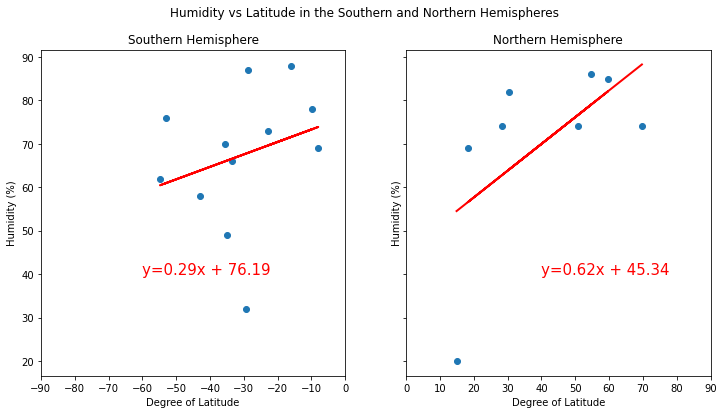

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Humidity vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs2, ys2)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Humidity (%)")
ax1.plot(xs2, regress_s2, color='red', linewidth=2)
ax1.annotate(line_eq_s2, (-60,40), fontsize=15, color="red")
ax2.scatter(xn2, yn2)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Humidity (%)")
ax2.plot(xn2, regress_n2, color="red", linewidth=2)
ax2.annotate(line_eq_n2, (40,40), fontsize=15, color="red")
plt.show()

In [38]:
print(f'The r-value of the southern hemisphere is {round(rvalue_s2,5)} and the r-value of the northern hemisphere is {round(rvalue_n2,5)}.')

The r-value of the southern hemisphere is 0.27503 and the r-value of the northern hemisphere is 0.59204.


In [39]:
# Northern Hemisphere - Cloudiness (%) vs. Latitude
# Southern Hemisphere - Cloudiness (%) vs. Latitude

# define values for northern hemisphere
xn3 = weather_north_df["Latitude"]
yn3 = weather_north_df["Cloudiness"].astype(int)

#calculate regression
(slope_n3, intercept_n3, rvalue_n3, pvalue_n3, stderr_n3) = linregress(xn3, yn3)
regress_n3 = xn3 * slope_n3 + intercept_n3
line_eq_n3 = "y=" + str(round(slope_n3,2)) + "x + " + str(round(intercept_n3,2))
print(line_eq_n3)

y=0.35x + 57.16


In [40]:
#define values for southern hemisphere
xs3 = weather_south_df["Latitude"]
ys3 = weather_south_df["Cloudiness"].astype(int)

#calculate regression
(slope_s3, intercept_s3, rvalue_s3, pvalue_s3, stderr_s3) = linregress(xs3, ys3)
regress_s3 = xs3 * slope_s3 + intercept_s3
line_eq_s3 = "y=" + str(round(slope_s3,2)) + "x + " + str(round(intercept_s3,2))
print(line_eq_s3)

y=0.42x + 72.9


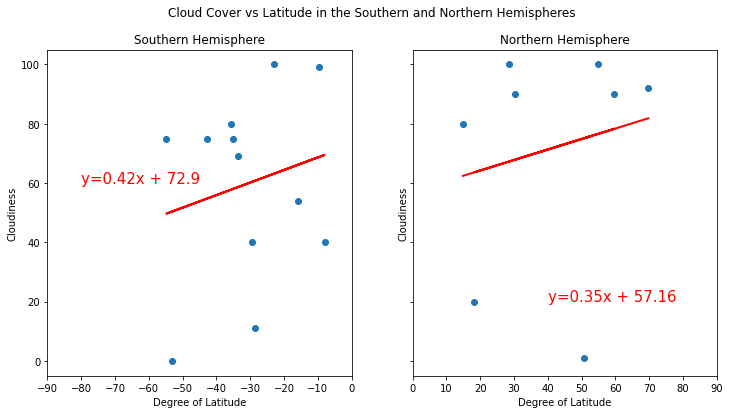

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Cloud Cover vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs3, ys3)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Cloudiness")
ax1.plot(xs3, regress_s3, color='red', linewidth=2)
ax1.annotate(line_eq_s3, (-80,60), fontsize=15, color="red")
ax2.scatter(xn3, yn3)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Cloudiness")
ax2.plot(xn3, regress_n3, color="red", linewidth=2)
ax2.annotate(line_eq_n3, (40,20), fontsize=15, color="red")
plt.show()

In [42]:
print(f'The r-value of the southern hemisphere is {round(rvalue_s3,5)} and the r-value of the northern hemisphere is {round(rvalue_n3,5)}.')

The r-value of the southern hemisphere is 0.20182 and the r-value of the northern hemisphere is 0.1878.


In [43]:
# Northern Hemisphere - Wind Speed (mph) vs. Latitude
# Southern Hemisphere - Wind Speed (mph) vs. Latitude

# define values for northern hemisphere
xn4 = weather_north_df["Latitude"]
yn4 = weather_north_df["Wind Speed (mph)"]

#calculate regression
(slope_n4, intercept_n4, rvalue_n4, pvalue_n4, stderr_n4) = linregress(xn4, yn4)
regress_n4 = xn4 * slope_n4 + intercept_n4
line_eq_n4 = "y=" + str(round(slope_n4,2)) + "x + " + str(round(intercept_n4,2))
print(line_eq_n4)

y=-0.11x + 12.96


In [44]:
#define values for southern hemisphere
xs4 = weather_south_df["Latitude"]
ys4 = weather_south_df["Max Temperature (F)"]

#calculate regression
(slope_s4, intercept_s4, rvalue_s4, pvalue_s4, stderr_s4) = linregress(xs4, ys4)
regress_s4 = xs4 * slope_s4 + intercept_s4
line_eq_s4 = "y=" + str(round(slope_s4,2)) + "x + " + str(round(intercept_s4,2))
print(line_eq_s4)

y=0.46x + 83.51


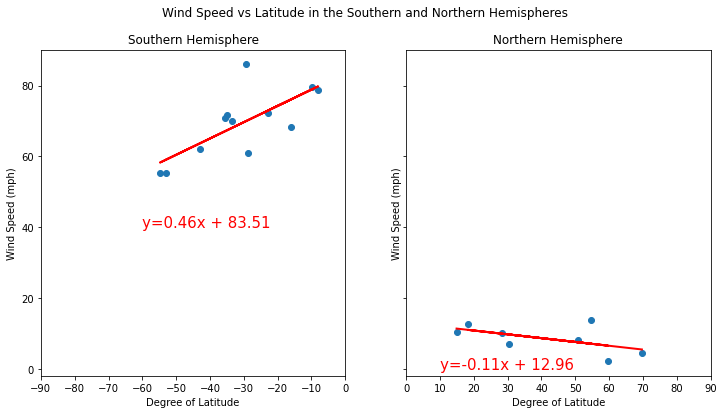

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Wind Speed vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs4, ys4)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel="Degree of Latitude", ylabel="Wind Speed (mph)")
ax1.plot(xs4, regress_s4, color='red', linewidth=2)
ax1.annotate(line_eq_s4, (-60,40), fontsize=15, color="red")
ax2.scatter(xn4, yn4)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Wind Speed (mph)")
ax2.plot(xn4, regress_n4, color="red", linewidth=2)
ax2.annotate(line_eq_n4, (10,0), fontsize=15, color="red")
plt.show()

In [45]:
print(f'The r-value of the southern hemisphere is {round(rvalue_s4,5)} and the r-value of the northern hemisphere is {round(rvalue_n4,5)}.')

The r-value of the southern hemisphere is 0.73068 and the r-value of the northern hemisphere is -0.55746.


In [ ]:
# After each pair of plots, take the time to explain what the linear regression is modeling. 
# For example, describe any relationships you notice and any other analysis you may have.